In [1]:
%load_ext autoreload
%autoreload 2
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [4]:
import sys
import os
import tigre
from scipy.signal import fftconvolve
from scipy.ndimage import convolve


sys.path.insert(0,'../xpecgen')

import fastcat.fastcat as fc

dose = 1

phan_map_hard =  ['air','water','Spongiosa_Bone_ICRP','G4_BONE_COMPACT_ICRU',
             'G4_BONE_CORTICAL_ICRP','C4_Vertebra_ICRP','D6_Vertebra_ICRP','G4_B-100_BONE']

phan_map_soft =  ['air','water','G4_ADIPOSE_TISSUE_ICRP','G4_BRAIN_ICRP',
             'G4_LUNG_ICRP','G4_MUSCLE_SKELETAL_ICRP','G4_TISSUE_SOFT_ICRP','pmma']

spectrum_files = ['Al_spectrum_25', 'C_spectrum_6', 'Al_spectrum_6', 'C_spectrum_25', 'W_spectrum_6', 'W_spectrum_25']

dets = ['CWO-392-micrometer','CuGOS-336-micrometer']

phan_maps = [phan_map_hard]#,phan_map_soft]

# angles = np.linspace(0,2*np.pi,90)

res = []

original_energies_keV = np.array([30, 40, 50 ,60, 70, 80 ,90 ,100 ,300 ,500 ,700, 900, 1000 ,2000 ,4000 ,6000])


angles = np.linspace(0,2*pi,360)

geo = 'catphan_low_contrast_512'

phantom = fc.Catphan_MTF()

for phan_map in phan_maps[:1]:
    for spectrum_file in spectrum_files[-2:-1]:
        for det in dets[1:]:
            s = fc.Spectrum()

            energies = []
            fluence = []

            with open(os.path.join(fc.data_path, "MV_spectra", f'{spectrum_file}.txt')) as f:
                for line in f:
                    energies.append(float(line.split()[0]))
                    fluence.append(float(line.split()[1]))

            # Check if MV

            s.x = np.array(energies)*1000  # to keV
            s.y = np.array(fluence)

            spectrum = fc.Spectrum()

            spectrum.x = energies
            spectrum.y = fluence

            kernel = fc.Kernel(s, det)

(19, 81, 81) 19


<IPython.core.display.Javascript object>


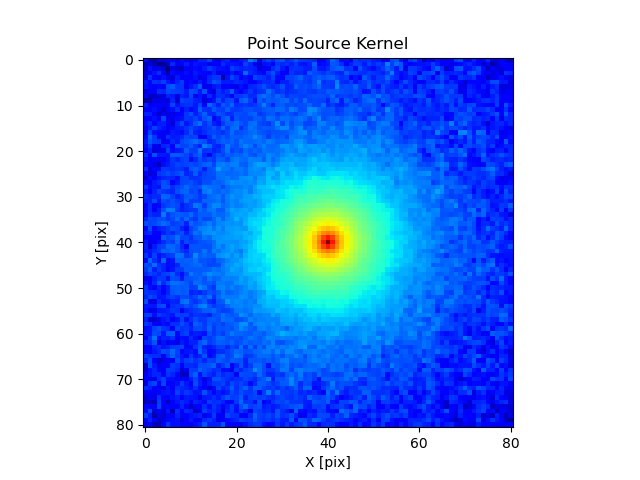

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)

kernel.get_plot(ax)

In [6]:
# Lets make a fake setup
# Very high res and then I'll bin it
# Then I'll convolve it

In [7]:
plot_stuff = True
plot_stuff_res = True

In [8]:
from scipy.interpolate import make_interp_spline, BSpline

<IPython.core.display.Javascript object>


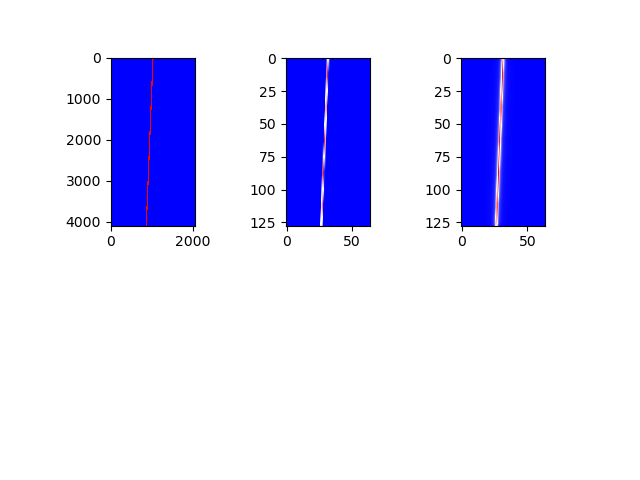

<IPython.core.display.Javascript object>


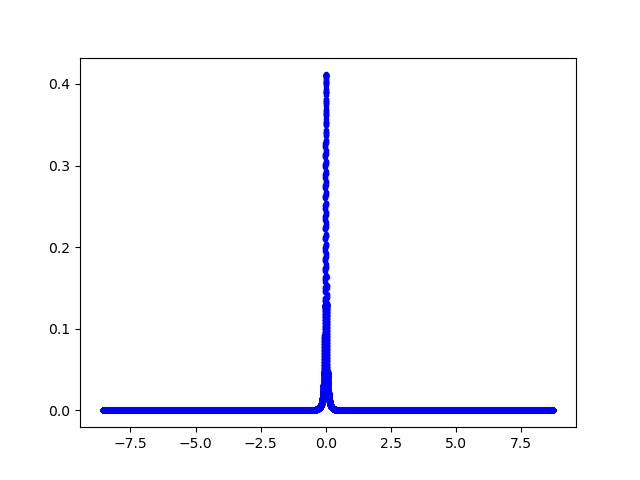

<IPython.core.display.Javascript object>


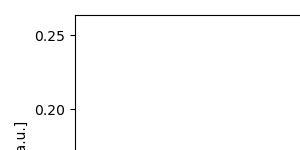

<IPython.core.display.Javascript object>


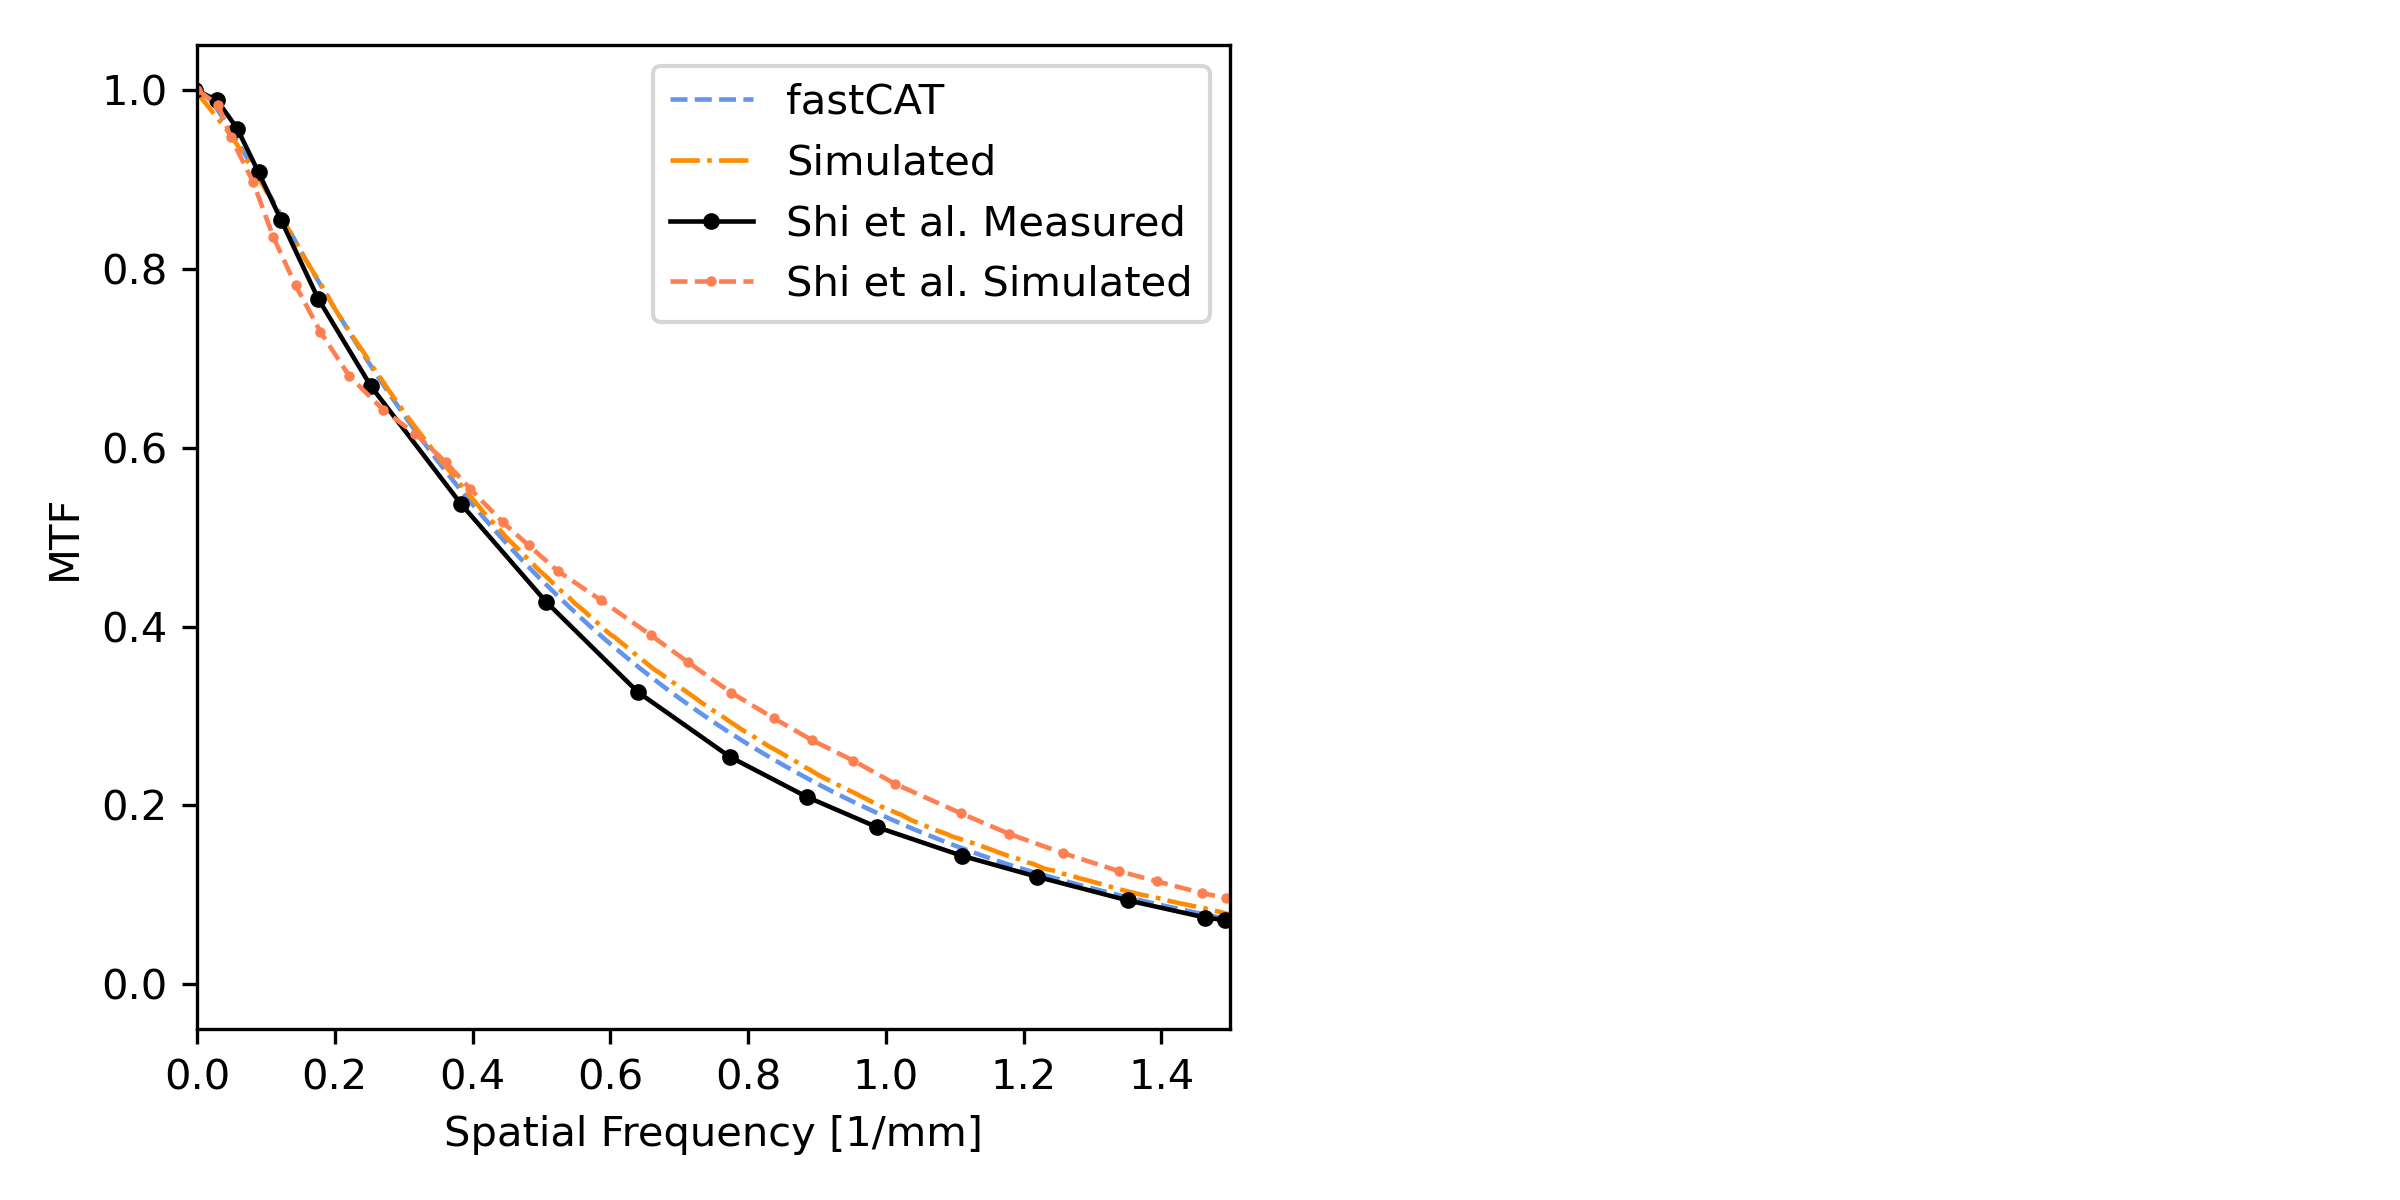

In [9]:
h,w = 1024*4,2*1024 #Wouldn't change tbh for building lsf
step = 16*2 #Wouldn't change tbh for building lsf
pitch = kernel.pitch #mm
angle = 2.3 #deg
lsf_width = 0.3 #mm Wouldn't change tbh
nbins = 818

# --- Make a high res line ---

high_res = np.zeros([h,w])
Y, X = np.mgrid[:h, :w]
dist_from_line = np.abs((X - high_res.shape[1]/2) + Y*tan(angle*pi/180))
# The MTF is from a 0.3 mm pixel times the angle times 16 since it will be averaged over 32 pix
num_pix = lsf_width*1/cos(angle*pi/180)/pitch*16
high_res[dist_from_line < num_pix] = 1

if plot_stuff:
    plt.figure()
    plt.subplot(231)
    plt.imshow(high_res,cmap='bwr',interpolation='none')
    plt.savefig('LSF1')

# --- Average to make low res line ---
# Ugly sorry
low_res = np.array([[np.mean(high_res[ii:ii+step,jj:jj+step]) 
                     for ii in range(0,h,step)] for jj in range(0,w,step)]).T

if plot_stuff:
    plt.subplot(232)
    plt.imshow(low_res,cmap='bwr')
    plt.savefig('LSF2')

# --- Convlolve with the kernel ---
lsf_image = fftconvolve(low_res,kernel.kernel/np.sum(kernel.kernel),mode = 'same')

if plot_stuff:
    plt.subplot(233)
    plt.imshow(lsf_image,cmap='bwr')
    plt.savefig('LSF3')

# --- Pad and presample ---
pad_len = int((512 - lsf_image.shape[1])/2)
lsf_image =  np.pad(lsf_image,((0,0),(pad_len,pad_len)),mode='constant')
Y, X = np.mgrid[:lsf_image.shape[0], :lsf_image.shape[1]]
center = int(lsf_image.shape[1]/2)
# pitch needs to convert to cm from mm
dist_from_line = (X + Y*tan(angle*pi/180) - center + 0.5)*pitch/10

if plot_stuff:
    plt.figure()
    plt.plot(dist_from_line[10:-10,:],lsf_image[10:-10,:],'b.')
    plt.savefig('LSF4')

# --- Crop the convolved edges ---
inds = np.argsort(dist_from_line[10:-10,:].flatten())
line = dist_from_line[10:-10,:].flatten()[inds]
lsf = lsf_image[10:-10,:].flatten()[inds]
n,bins = np.histogram(line,nbins,weights=lsf,density=True)

n2 = np.load('data/full_n.npy')
bins2 = np.load('data/full_bins.npy') -0.0085

bins -= 0.0085

if plot_stuff:
    plt.figure()
    plt.plot(bins[1:],n/(np.sum(n)),'x',linewidth= 1.1,markersize=5,color='cornflowerblue')
    plt.plot(bins2[1:],n2/np.sum(n2),'ko',linewidth= 1.1,markersize=3)

    xnew = np.linspace(bins[1:].min(), bins[1:].max(), 5000) 
    spl = make_interp_spline(bins[1:], n/(np.sum(n)), k=3)  # type: BSpline
    power_smooth = spl(xnew)
    
    plt.plot(xnew,power_smooth,'-',linewidth= 1.1,markersize=5,color='cornflowerblue')
    
    xnew2 = np.linspace(bins2[1:].min(), bins2[1:].max(), 5000) 
    spl2 = make_interp_spline(bins2[1:], n2/(np.sum(n2)), k=3)  # type: BSpline
    power_smooth2 = spl2(xnew2)
    
    plt.plot(xnew2,power_smooth2,'k:',linewidth= 1.1,markersize=3)

    
#     plt.title('PSF from LSF Cu-GOS')
    plt.legend(['fastcat','Simulated'])
    plt.xlabel('Distance [mm]')
    plt.ylabel('Normalized amplitude [a.u.]')
    plt.xlim([-0.2,0.2])
    plt.tight_layout()
#     plt.savefig('LSF_good')
#     plt.savefig('LSF5')


mtf = np.absolute(np.fft.fft(power_smooth))
mtf_final = np.fft.fftshift(mtf)
N = len(mtf)
T = np.mean(np.diff(xnew))
xf = np.linspace(0.0, 1.0/(2.0*T), int((N-1)/2))
mm = np.argmax(mtf_final)
    
if plot_stuff_res:
    plt.figure(27,dpi=300,figsize=[8,4])
    plt.subplot(121)
    plt.plot(xf/10,mtf_final[mm+1:]/mtf_final[mm+1],'--',linewidth= 1.1,markersize=2,color='cornflowerblue')
    
    # plt.legend([])
    # plt.xlim([0,15])

    shi_data = [-0.0036600255852107244, 0.9985732893897139,
    0.028883896178828306, 0.9869637814824851,
    0.05821655345648036, 0.9552964008777066,
    0.08921020960640147, 0.9064175751164883,
    0.1218386383306087, 0.8532306428065635,
    0.17567540002389503, 0.7655438897096748,
    0.25229698659836164, 0.6677232950720785,
    0.38264460160796343, 0.5366967103480229,
    0.5064443842210934, 0.42720366468803805,
    0.6399828654853176, 0.326270882689769,
    0.7734630660873568, 0.25401218648646273,
    0.8857495038858628, 0.20908478962137955,
    0.9866304160947875, 0.17567598283051677,
    1.1102728409200182, 0.14360296881693158,
    1.2192635072719695, 0.1201951236569948,
    1.3510244283395543, 0.09382195840509122,
    1.4632584135420945, 0.07470123875547463,
    1.4925327901575614, 0.07170794394565894]

    shi_data_sim = [0, 1.0028606704405152,
    0.03089430894308942, 0.9856244321755537,
    0.04878048780487804, 0.9497821883662961,
    0.08130081300813002, 0.8995923311668645,
    0.11056910569105688, 0.8379458149882357,
    0.14308943089430892, 0.7834579635194632,
    0.1788617886178861, 0.7318307824912058,
    0.22113821138211376, 0.6816269480746382,
    0.26991869918699185, 0.6443077783213361,
    0.31707317073170727, 0.6170195913993523,
    0.36097560975609744, 0.5854380692804062,
    0.3967479674796748, 0.5553008595988538,
    0.4439024390243902, 0.517984019381741,
    0.4813008130081301, 0.4921424744333402,
    0.5235772357723576, 0.46342861136347735,
    0.5869918699186991, 0.43038647005381225,
    0.6585365853658535, 0.39160202203741235,
    0.7121951219512195, 0.36143918745777703,
    0.7756097560975608, 0.32696438139166484,
    0.8373983739837396, 0.2982225638875299,
    0.8926829268292682, 0.27378805879749335,
    0.9528455284552844, 0.25077922985533563,
    1.0130081300813008, 0.22490507140028415,
    1.1089430894308943, 0.19181633936683207,
    1.1788617886178858, 0.16879353320753832,
    1.2569105691056908, 0.1471917441237448,
    1.3382113821138208, 0.12701796072401972,
    1.3934959349593494, 0.11547743844200609,
    1.4585365853658534, 0.10249027418640944,
    1.4943089430894305, 0.09670836536445593]

    shi_sim_x = shi_data_sim[::2]
    shi_sim_y = shi_data_sim[1::2]

    shi_x = shi_data[::2]
    shi_y = shi_data[1::2]


    mtf = np.absolute(np.fft.fft(power_smooth2))
    mtf_final2 = np.fft.fftshift(mtf)
    N = len(mtf)
    T = np.mean(np.diff(xnew2))
    xf2 = np.linspace(0.0, 1.0/(2.0*T), int((N-1)/2))
    mm2 = np.argmax(mtf_final2)
    
    plt.plot(xf2/10,mtf_final2[mm2+1:]/mtf_final2[mm2+1],'-.',linewidth= 1.1,markersize=2,color='darkorange')

    #     plt.plot(star_x,np.array(star_y)/star_y[0])
    plt.plot(shi_x,np.array(shi_y)/shi_y[0],'ko-',linewidth= 1.1,markersize=3)
    plt.plot(shi_sim_x,np.array(shi_sim_y)/shi_sim_y[0],'.--',linewidth= 1.1,markersize=3,color='coral')

    plt.legend(['fastCAT','Simulated','Shi et al. Measured','Shi et al. Simulated'])
    plt.xlim((0,1.5))
    plt.xlabel('Spatial Frequency [1/mm]')
    plt.ylabel('MTF')
    plt.tight_layout()
    #plt.savefig('Shi_Comparison_good')

In [11]:
plt.close('all')

In [12]:
int_mtf = np.interp(shi_x,xf/10,mtf_final[mm+1:]/mtf_final[mm+1])

In [13]:
shi = [0,0.99999999
,0.025,0.991797133286085
,0.05,0.968530238193482
,0.075,0.93380343791949
,0.1,0.892399087235391
,0.125,0.848974889456598
,0.15,0.807033050080458
,0.175,0.768471362196807
,0.2,0.733732849396345
,0.225,0.7023259341506
,0.25,0.673403205657376
,0.275,0.646169502665262
,0.3,0.620052638074322
,0.325,0.594703066426028
,0.35,0.569931148207218
,0.375,0.545654895925913
,0.4,0.521873081762403
,0.425,0.498646197906965
,0.45,0.476070619838188
,0.475,0.45424855735644
,0.5,0.433265025203723
,0.525,0.413177856461524
,0.55,0.3940176166628
,0.575,0.375791103597351
,0.6,0.358485294602962
,0.625,0.342072082410802
,0.65,0.326514080505468
,0.675,0.311769947027926
,0.7,0.297797557002672
,0.725,0.284555329143253
,0.75,0.272003443392743
,0.775,0.260105752764239
,0.8,0.248831190811567
,0.825,0.238152974950971
,0.85,0.228045558651841
,0.875,0.218481224845002
,0.9,0.209428409015062
,0.925,0.2008523165279
,0.95,0.192716847827772
,0.975,0.184986544600491
,1,0.17762792927205
,1.025,0.170610194660805
,1.05,0.163905302413474
,1.075,0.157487575644027
,1.1,0.151333142954107
,1.125,0.145419785262876
,1.15,0.139727408174819
,1.175,0.13423870401224
,1.2,0.128939296186215
,1.225,0.123817139245916
,1.25,0.11886169684499
,1.275,0.1140636340476
,1.3,0.109415225282377
,1.325,0.104910974938282
,1.35,0.100547769961988
,1.375,0.096324322587916
,1.4,0.092240216237191
,1.425,0.088295052561172
,1.45,0.084487982036502
,1.475,0.080817585748069
,1.5,0.077281909842579
,1.525,0.073878465346741
,1.55,0.07060412134182
,1.575,0.067454978002738
,1.6,0.064426425869089
,1.625,0.061513555235527
,1.65,0.058711839001376
,1.675,0.056017749918254
,1.7,0.053428956273566
,1.725,0.050944031064079
,1.75,0.048561951290841
,1.775,0.046281731522501
,1.8,0.044102291647602
,1.825,0.042022390781445
,1.85,0.040040451854553
,1.875,0.038154322998607
,1.9,0.036361187929553
,1.925,0.034657751816576
,1.95,0.03304059255264
,1.975,0.031506433742092
,2,0.030052180639764
,2.025,0.028674747795461
,2.05,0.027370821352329
,2.075,0.026136693935058
,2.1,0.024968260404987
,2.125,0.023861219739743
,2.15,0.022811460857749
,2.175,0.021815496327733
,2.2,0.020870720428104
,2.225,0.019975313200122
,2.25,0.019127792995262
,2.275,0.018326407847648
,2.3,0.017568615488318
,2.325,0.016850820848858
,2.35,0.016168416719734
,2.375,0.015516093775402
,2.4,0.014888347084873
,2.425,0.014280062925665
,2.45,0.013687026434713
,2.475,0.013106205421141
,2.5,0.012535764686008
,2.525,0.011974884078509
,2.55,0.011423492762145
,2.575,0.010881969109339
,2.6,0.010350778694241
,2.625,0.009830039411734
,2.65,0.009319118029261
,2.675,0.008816461765391
,2.7,0.00831982594192
,2.725,0.007826865198316
,2.75,0.007335839998125
,2.775,0.006846113794623
,2.8,0.006358239736817
,2.825,0.005873671874088
,2.85,0.005394321647871
,2.875,0.004922202169475
,2.9,0.00445927252998
,2.925,0.004007427624745
,2.95,0.003568499878026
,2.975,0.003144191129415]

<IPython.core.display.Javascript object>


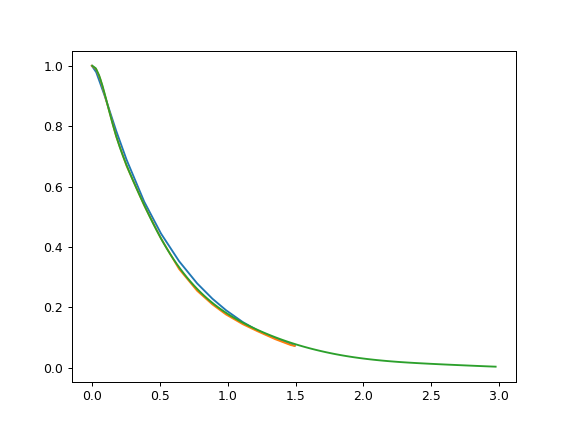

In [14]:
plt.figure()
plt.plot(shi_x,int_mtf)
plt.plot(shi_x,np.array(shi_y)/shi_y[0])
plt.plot(shi[::2],shi[1::2])

Looking at the difference between measured and actual

In [15]:
np.mean(np.abs(int_mtf- np.array(shi_y)/shi_y[0]))

0.011091160574736131

In [16]:
np.max(np.abs(int_mtf- np.array(shi_y)/shi_y[0]))

0.025785904779349555

In [17]:
shi_y[9]/shi_y[0]

0.326737041894213

In [18]:
np.mean(np.abs(int_mtf- np.array(shi_y)/shi_y[0]))

0.011091160574736131

Looking at the simulation

In [19]:
np.mean(np.abs(mtf_final[mm+1:]/mtf_final[mm+1] - mtf_final2[mm2+1:]/mtf_final2[mm2+1]))

0.007882510543712628

In [20]:
np.max(np.abs(mtf_final[mm+1:]/mtf_final[mm+1] - mtf_final2[mm2+1:]/mtf_final2[mm2+1]))

0.0779121217709049

In [21]:
shi_y[9]/shi_y[0]

0.326737041894213

In [22]:
np.mean(np.abs(sim)

SyntaxError: unexpected EOF while parsing (<ipython-input-22-3b9bbe9b4145>, line 1)

### CWO 

In [23]:
import sys
import os
import tigre
from scipy.signal import fftconvolve
from scipy.ndimage import convolve


sys.path.insert(0,'../xpecgen')

import xpecgen as xg

dose = 1

phan_map_hard =  ['air','water','Spongiosa_Bone_ICRP','G4_BONE_COMPACT_ICRU',
             'G4_BONE_CORTICAL_ICRP','C4_Vertebra_ICRP','D6_Vertebra_ICRP','G4_B-100_BONE']

phan_map_soft =  ['air','water','G4_ADIPOSE_TISSUE_ICRP','G4_BRAIN_ICRP',
             'G4_LUNG_ICRP','G4_MUSCLE_SKELETAL_ICRP','G4_TISSUE_SOFT_ICRP','pmma']

spectrum_files = ['Al_spectrum_25', 'C_spectrum_6', 'Al_spectrum_6', 'C_spectrum_25', 'W_spectrum_6', 'W_spectrum_25']

dets = ['CWO-392-micrometer','CuGOS-336-micrometer']

phan_maps = [phan_map_hard]#,phan_map_soft]

# angles = np.linspace(0,2*np.pi,90)

res = []

original_energies_keV = np.array([30, 40, 50 ,60, 70, 80 ,90 ,100 ,300 ,500 ,700, 900, 1000 ,2000 ,4000 ,6000])


angles = np.linspace(0,2*pi,360)

geo = 'catphan_low_contrast_512'

phantom = xg.Catphan_MTF()

for phan_map in phan_maps[:1]:
    for spectrum_file in spectrum_files[-2:-1]:
        for det in dets[:1]:
            s = xg.Spectrum()

            energies = []
            fluence = []

            with open(os.path.join(xg.data_path, "MV_spectra", f'{spectrum_file}.txt')) as f:
                for line in f:
                    energies.append(float(line.split()[0]))
                    fluence.append(float(line.split()[1]))

            # Check if MV

            s.x = np.array(energies)*1000  # to keV
            s.y = np.array(fluence)

            spectrum = xg.Spectrum()

            spectrum.x = energies
            spectrum.y = fluence

            kernel = xg.Kernel(s, det)

<IPython.core.display.Javascript object>


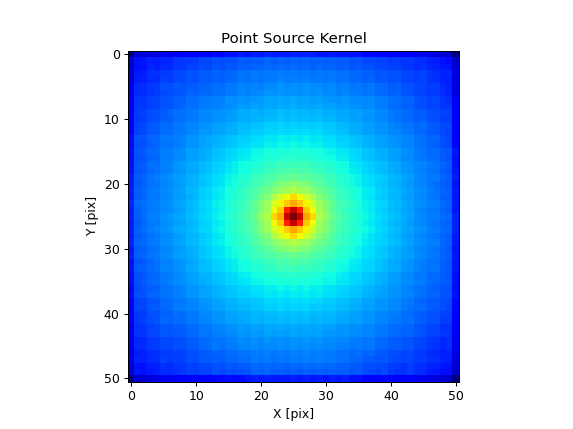

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)

kernel.get_plot(ax)

In [25]:
# Lets make a fake setup
# Very high res and then I'll bin it
# Then I'll convolve it

In [26]:
plot_stuff = False
plot_stuff_res = True

<IPython.core.display.Javascript object>


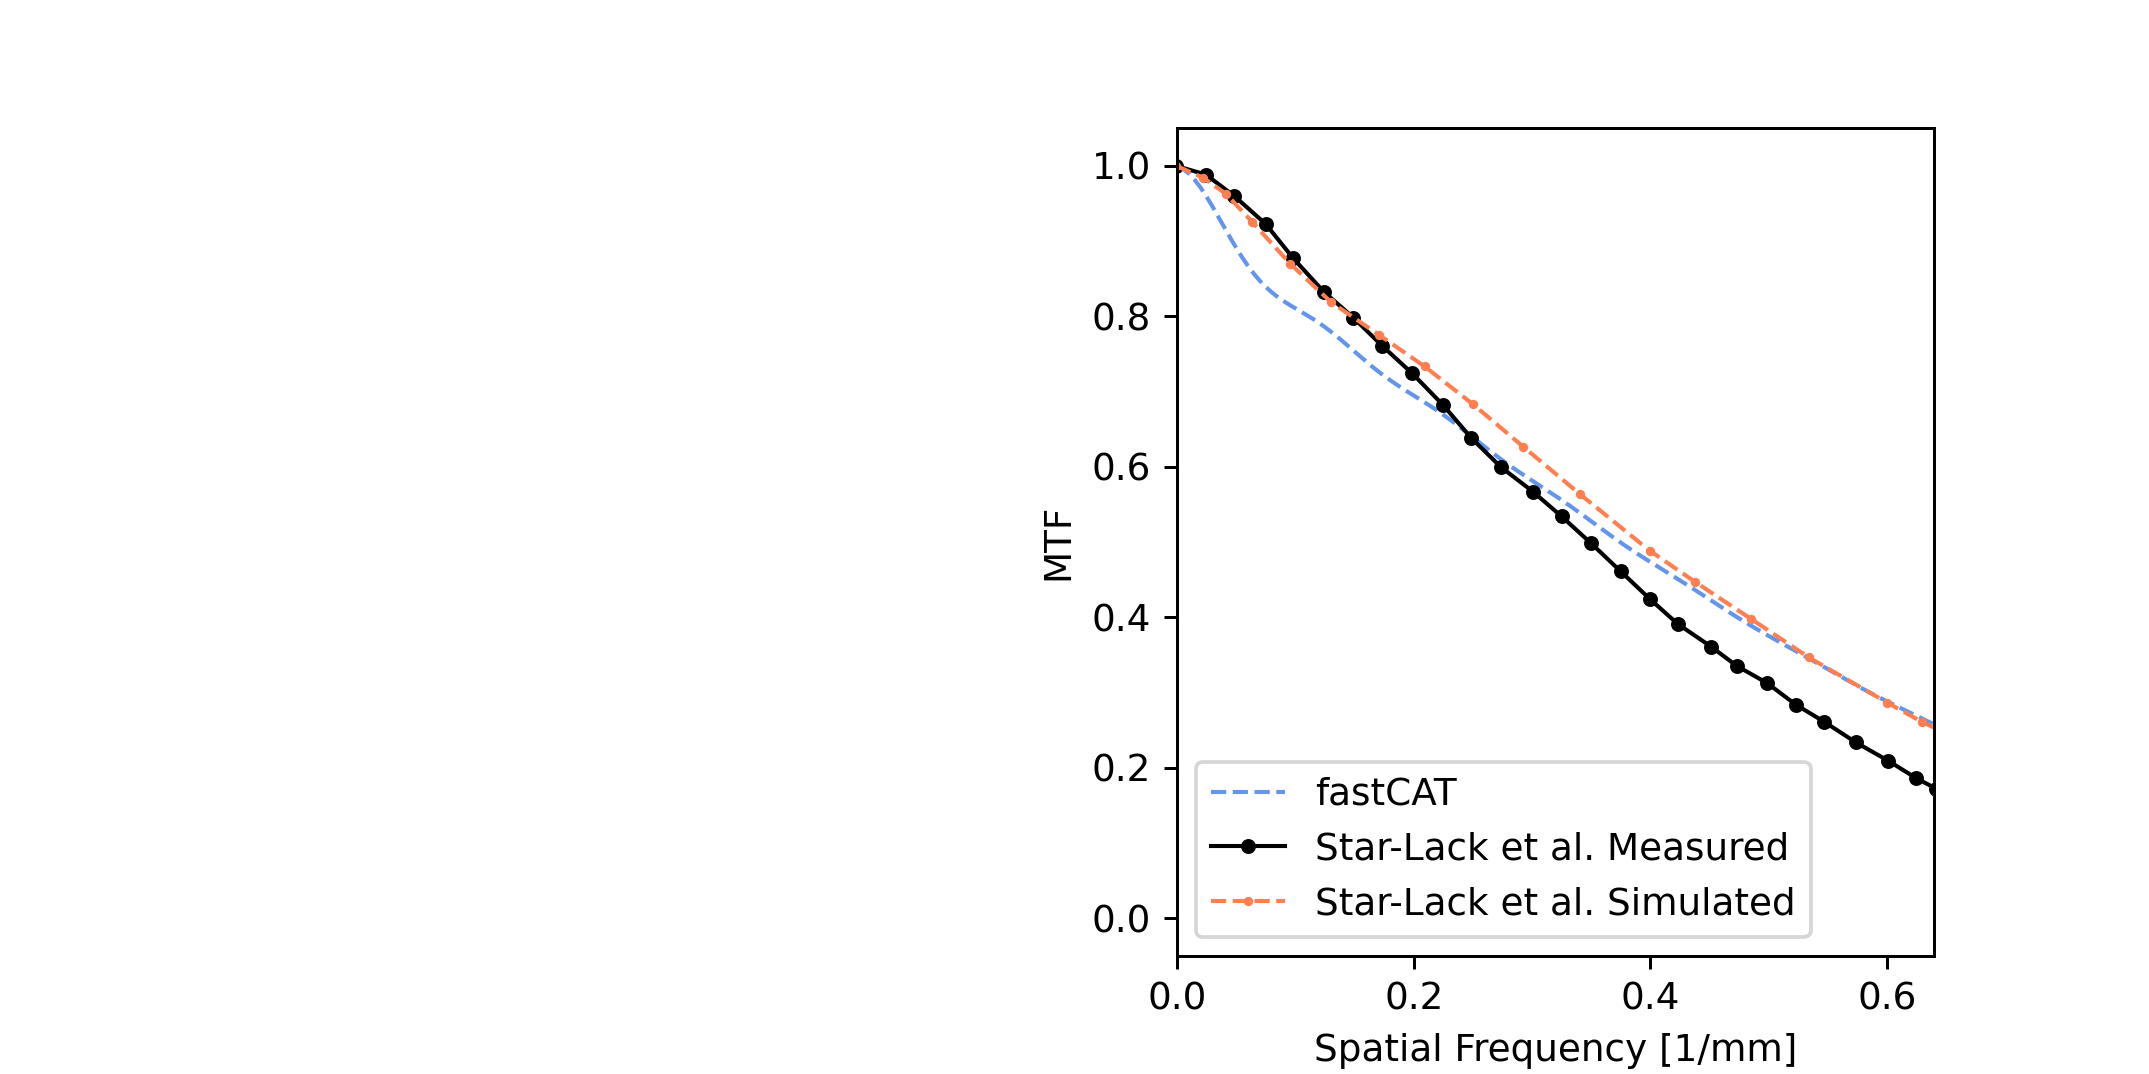

In [27]:
for ii in [818]:

    h,w = 1024*4,2*1024 #Wouldn't change tbh for building lsf
    step = 16*2 #Wouldn't change tbh for building lsf
    pitch = kernel.pitch #mm
    angle = 2.3 #deg
    lsf_width = 0.3 #mm Wouldn't change tbh
    nbins = ii

    # --- Make a high res line ---

    high_res = np.zeros([h,w])
    Y, X = np.mgrid[:h, :w]
    dist_from_line = np.abs((X - high_res.shape[1]/2) + Y*tan(angle*pi/180))
    # The MTF is from a 0.3 mm pixel times the angle times 16 since it will be averaged over 32 pix
    num_pix = lsf_width*1/cos(angle*pi/180)/pitch*16
    high_res[dist_from_line < num_pix] = 1

    if plot_stuff:
        plt.figure()
        plt.imshow(high_res)

    # --- Average to make low res line ---
    # Ugly sorry
    low_res = np.array([[np.mean(high_res[ii:ii+step,jj:jj+step]) 
                         for ii in range(0,h,step)] for jj in range(0,w,step)]).T

    if plot_stuff:
        plt.figure()
        plt.imshow(low_res)

    # --- Convlolve with the kernel ---
    lsf_image = fftconvolve(low_res,kernel.kernel/np.sum(kernel.kernel),mode = 'same')

    if plot_stuff:
        plt.figure()
        plt.imshow(lsf_image)

    # --- Pad and presample ---
    pad_len = int((512 - lsf_image.shape[1])/2)
    lsf_image =  np.pad(lsf_image,((0,0),(pad_len,pad_len)),mode='constant')
    Y, X = np.mgrid[:lsf_image.shape[0], :lsf_image.shape[1]]
    center = int(lsf_image.shape[1]/2)
    # pitch needs to convert to cm from mm
    dist_from_line = (X + Y*tan(angle*pi/180) - center + 0.5)*pitch/10

    if plot_stuff:
        plt.figure()
        plt.plot(dist_from_line[10:-10,:],lsf_image[10:-10,:],'b.')

    # --- Crop the convolved edges ---
    inds = np.argsort(dist_from_line[10:-10,:].flatten())
    line = dist_from_line[10:-10,:].flatten()[inds]
    lsf = lsf_image[10:-10,:].flatten()[inds]
    n,bins = np.histogram(line,nbins,weights=lsf,density=True)

    n2 = np.load('data/full_n.npy')
    bins2 = np.load('data/full_bins.npy')

    if plot_stuff:
        plt.figure()
        plt.plot(bins[1:],n/(np.sum(n)),'x-',linewidth= 1.1,markersize=5,color='cornflowerblue')
        plt.plot(bins2[1:],n2/np.sum(n2),'ko-',linewidth= 1.1,markersize=3)
        plt.title('LSF')
        plt.legend(['fastCAT','geant4'])
        plt.xlabel('[mm]')
        plt.ylabel('Normalized Amplitude')
        plt.xlim([-0.5,0.5])
        plt.savefig('LSF_good')

    mtf = np.absolute(np.fft.fft(n))
    mtf_final = np.fft.fftshift(mtf)
    N = len(mtf)
    T = np.mean(np.diff(bins))
    xf = np.linspace(0.0, 1.0/(2.0*T), int((N-1)/2))
    mm = np.argmax(mtf_final)

    if plot_stuff_res:
        plt.figure(27,dpi=300,figsize=[8,4])
        plt.subplot(122)
        plt.plot(xf/10,mtf_final[mm+1:]/mtf_final[mm+1],'--',linewidth= 1.1,markersize=2,color='cornflowerblue')
        # plt.legend([])
        # plt.xlim([0,15])

        star_data = [-0.0007792207792207684, 1.0028635434517787,
        0.024155844155844167, 0.9913573390043979,
        0.04831168831168832, 0.962682881506411,
        0.07480519480519482, 0.9254177936530879,
        0.0981818181818182, 0.879575083104495,
        0.12389610389610392, 0.835157640451758,
        0.14883116883116884, 0.800757954287366,
        0.172987012987013, 0.7634984411454999,
        0.1987012987012987, 0.7262352115293291,
        0.2244155844155844, 0.6846794540912188,
        0.2485714285714286, 0.6402657279127868,
        0.27350649350649353, 0.6015735139264551,
        0.30077922077922076, 0.5685990956579191,
        0.32493506493506497, 0.5356321103379926,
        0.3498701298701299, 0.4998015815662874,
        0.3748051948051948, 0.4625402101872689,
        0.3997402597402598, 0.42527883880825046,
        0.42311688311688317, 0.39231371172547636,
        0.45116883116883116, 0.3621991204344145,
        0.4729870129870129, 0.33639192286251096,
        0.4987012987012987, 0.31343711931947216,
        0.5228571428571429, 0.28476266182148524,
        0.547012987012987, 0.2618115747527512,
        0.5735064935064935, 0.2345623851506203,
        0.6007792207792209, 0.2101730225259636,
        0.6241558441558441, 0.1872237936943818,
        0.6412987012987013, 0.17287448640389802,]

        star_data_sim = [-0.0006060606060605822, 1.0025319169436817,
        0.02194083694083697, 0.9867455040984453,
        0.04133116883116887, 0.9651703814203815,
        0.06342712842712847, 0.927856162120868,
        0.095443722943723, 0.8723015385515385,
        0.1301659451659452, 0.8208806323512206,
        0.17029942279942284, 0.7777271608889255,
        0.20908008658008664, 0.735404949449067,
        0.2501154401154402, 0.6847970220029043,
        0.2925036075036076, 0.6283896310366897,
        0.34030303030303044, 0.5653450643156523,
        0.399375901875902, 0.4898531046325162,
        0.4379220779220781, 0.4480812669047961,
        0.48467532467532476, 0.3993211240270060,
        0.5337662337662339, 0.3476937212231327,
        0.6000000000000001, 0.2874403815580284,
        0.6296103896103897, 0.26161460161460126,
        0.642857142857143, 0.2515671133318188]

        shi_sim_x = star_data_sim[::2]
        shi_sim_y = star_data_sim[1::2]

        shi_x = star_data[::2]
        shi_y = star_data[1::2]


        #     plt.plot(star_x,np.array(star_y)/star_y[0])
        plt.plot(shi_x,np.array(shi_y)/shi_y[0],'ko-',linewidth= 1.1,markersize=3)
        plt.plot(shi_sim_x,np.array(shi_sim_y)/shi_sim_y[0],'.--',linewidth= 1.1,markersize=3,color='coral')

        plt.legend(['fastCAT','Star-Lack et al. Measured','Star-Lack et al. Simulated'])
        plt.xlim((0,0.64))
        plt.xlabel('Spatial Frequency [1/mm]')
        plt.ylabel('MTF')
#         plt.savefig('Star_Comparison_good')

In [60]:
plt.close('all')

In [29]:
int_mtf = np.interp(shi_x,xf/10,mtf_final[mm+1:]/mtf_final[mm+1])

<IPython.core.display.Javascript object>


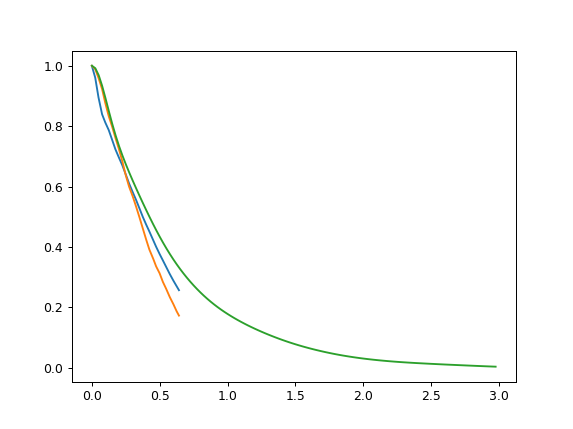

In [30]:
plt.figure()
plt.plot(shi_x,int_mtf)
plt.plot(shi_x,np.array(shi_y)/shi_y[0])
plt.plot(shi[::2],shi[1::2])

Looking at the difference between measured and actual

In [31]:
np.mean(np.abs(int_mtf- np.array(shi_y)/shi_y[0]))

0.04782580638353056

In [32]:
np.max(np.abs(int_mtf- np.array(shi_y)/shi_y[0]))

0.08415598012807884

In [33]:
np.argmax(np.abs(int_mtf- np.array(shi_y)/shi_y[0]))

26

In [35]:
shi_x[26]

0.6412987012987013

In [34]:
shi_y[26]/shi_y[0]

0.17238086630298416

In [18]:
np.mean(np.abs(int_mtf- np.array(shi_y)/shi_y[0]))

0.011091160574736131

Looking at the simulation

In [19]:
np.mean(np.abs(mtf_final[mm+1:]/mtf_final[mm+1] - mtf_final2[mm2+1:]/mtf_final2[mm2+1]))

0.007882510543712628

In [20]:
np.max(np.abs(mtf_final[mm+1:]/mtf_final[mm+1] - mtf_final2[mm2+1:]/mtf_final2[mm2+1]))

0.0779121217709049

In [21]:
shi_y[9]/shi_y[0]

0.326737041894213

In [22]:
np.mean(np.abs(sim)

SyntaxError: unexpected EOF while parsing (<ipython-input-22-3b9bbe9b4145>, line 1)

In [33]:
plt.tight_layout()
plt.savefig('/home/xcite/fastcat_paper/figures/MTF.pdf')

In [26]:
plt.close('all')

In [16]:
center = int(kernel.kernel.shape[0]/2)
lsf = kernel.kernel[center,:]

N = kernel.kernel.shape[0]

# if N < 40:
# T = 0.784
# else:
T = 0.336

xf = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

mtf = np.absolute(np.fft.fft(lsf))
mtf_final = np.fft.fftshift(mtf)

nn = 0

fig = plt.figure(1)
place = fig.add_subplot(111)
place.plot(xf[:center-nn],mtf_final[center:center + center-nn]/mtf_final[center+2])
place.set_title('MTF from Kernel')
place.set_xlabel('Spacial Frequency [1/mm]')
place.set_ylabel('MTF')
place.grid()

shi_data = [-0.0036600255852107244, 0.9985732893897139,
0.028883896178828306, 0.9869637814824851,
0.05821655345648036, 0.9552964008777066,
0.08921020960640147, 0.9064175751164883,
0.1218386383306087, 0.8532306428065635,
0.17567540002389503, 0.7655438897096748,
0.25229698659836164, 0.6677232950720785,
0.38264460160796343, 0.5366967103480229,
0.5064443842210934, 0.42720366468803805,
0.6399828654853176, 0.326270882689769,
0.7734630660873568, 0.25401218648646273,
0.8857495038858628, 0.20908478962137955,
0.9866304160947875, 0.17567598283051677,
1.1102728409200182, 0.14360296881693158,
1.2192635072719695, 0.1201951236569948,
1.3510244283395543, 0.09382195840509122,
1.4632584135420945, 0.07470123875547463,
1.4925327901575614, 0.07170794394565894]

shi_x = shi_data[::2]
shi_y = shi_data[1::2]

star_data = [0.0043086409992885155, 0.9784172661870504,
0.07416396553087196, 0.8705035971223021,
0.17022689540675146, 0.7248201438848921,
0.2729860067989565, 0.6025179856115108,
0.3736105620997708, 0.4946043165467626,
0.4502174084907898, 0.42266187050359716,
0.5312593880939205, 0.3597122302158273,
0.6364455688196695, 0.289568345323741,
0.7394971934540282, 0.23381294964028776,
0.8491659419716973, 0.1834532374100719,
0.9786465333227923, 0.14028776978417268,
1.1191240414261996, 0.09892086330935257,
1.2442801802514032, 0.07194244604316546,
1.2904024033520434, 0.06474820143884896]

star_x = star_data[::2]
star_y = star_data[1::2]

plt.plot(shi_x,shi_y)
plt.plot(star_x,star_y)

/home/xcite/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<IPython.core.display.Javascript object>


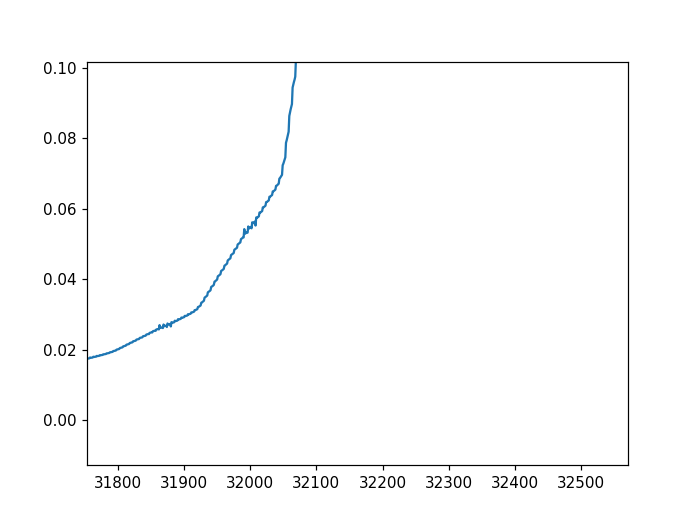

In [73]:
plt.figure()
plt.plot(lsf)

In [583]:
ax = plt.gca()

In [ ]:
ax.legend

<IPython.core.display.Javascript object>


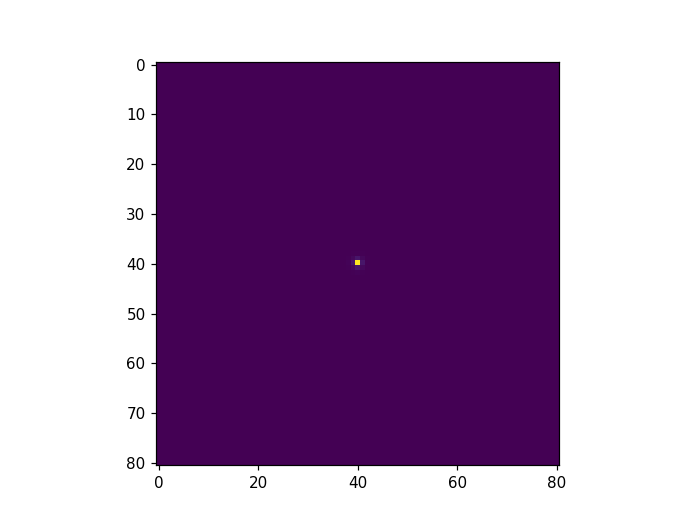

In [63]:
plt.figure()
plt.imshow(kernel.kernel)

In [53]:
plt.close('all')